## Libraries

In [20]:
from ultralytics import YOLO
import os
from IPython.display import display, Image
from IPython import display
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import shutil
from joblib import Parallel, delayed
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

## Print random image

In [13]:
csv_path = r"spark-2024-train-val/train.csv"
df = pd.read_csv(csv_path)
df

,Image name,Mask name,Class,Bounding box
0,image_00001_img.jpg,image_00001_layer.jpg,Cheops,"(397, 253, 653, 486)"
1,image_00002_img.jpg,image_00002_layer.jpg,Cheops,"(62, 251, 489, 592)"
2,image_00003_img.jpg,image_00003_layer.jpg,Cheops,"(669, 525, 935, 770)"
3,image_00004_img.jpg,image_00004_layer.jpg,Cheops,"(92, 604, 419, 935)"
4,image_00005_img.jpg,image_00005_layer.jpg,Cheops,"(525, 509, 770, 754)"
...,...,...,...,...
59995,image_09996_img.jpg,image_09996_layer.jpg,XMM Newton,"(124, 394, 499, 919)"
59996,image_09997_img.jpg,image_09997_layer.jpg,XMM Newton,"(552, 353, 891, 465)"
59997,image_09998_img.jpg,image_09998_layer.jpg,XMM Newton,"(243, 0, 614, 565)"
59998,image_09999_img.jpg,image_09999_layer.jpg,XMM Newton,"(475, 156, 900, 531)"


Image name        image_03126_img.jpg
Mask name       image_03126_layer.jpg
Class                  LisaPathfinder
Bounding box     (472, 540, 722, 870)
Name: 7895, dtype: object
Image path: spark-2024-train-val\images\LisaPathfinder\train\image_03126_img.jpg
Image size: 1024 x 1024


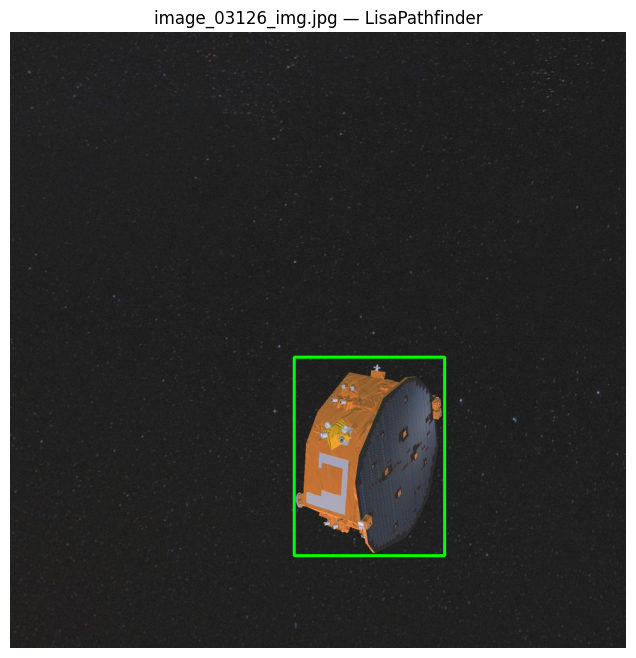

In [18]:
row = df.sample(1).iloc[0] # random example
print(row)

img_name = row["Image name"]
mask_name = row["Mask name"]
cls = row["Class"]
bbox_str = row["Bounding box"]

split = "train"

img_path = os.path.join(
    r"spark-2024-train-val",
    "images",
    cls,
    split,
    img_name
)
print("Image path:", img_path)

img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Image not found: {img_path}")

h, w = img.shape[:2]
print("Image size:", w, "x", h)

# parse bounding box "(x1, y1, x2, y2)"
x1, y1, x2, y2 = [int(x) for x in bbox_str.strip("()").split(",")]

img2 = img.copy()
cv2.rectangle(img2, (x1, y1), (x2, y2), (0, 255, 0), 3)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(img2)
plt.title(f"{img_name} — {cls}")
plt.axis("off")
plt.show()

## Dataset conversion to YOLO format

In [21]:
ROOT = r"spark-2024-train-val"
TRAIN_CSV = os.path.join(ROOT, "train.csv")
VAL_CSV = os.path.join(ROOT, "val.csv")

YOLO_OUT = "spark-yolo-100%"
IMG_TRAIN = os.path.join(YOLO_OUT, "images", "train")
IMG_VAL   = os.path.join(YOLO_OUT, "images", "val")
LAB_TRAIN = os.path.join(YOLO_OUT, "labels", "train")
LAB_VAL   = os.path.join(YOLO_OUT, "labels", "val")

for d in [IMG_TRAIN, IMG_VAL, LAB_TRAIN, LAB_VAL]:
    os.makedirs(d, exist_ok=True)

class_to_id = {
    "VenusExpress": 0,
    "Cheops": 1,
    "LisaPathfinder": 2,
    "ObservationSat1": 3,
    "Proba2": 4,
    "Proba3": 5,
    "Proba3ocs": 6,
    "Smart1": 7,
    "Soho": 8,
    "XMM Newton": 9
}

### Unoptimized version

In [ ]:
def yolo_conversion_old(csv_path, split_name, img_out, lab_out):
    df = pd.read_csv(csv_path)
    print(f"{split_name}: totale righe = {len(df)}")

    #df = df.sample(frac=0.1, random_state=42)
    #print(f"-> selected {len(df)} images ({split_name})")

    for idx, row in df.iterrows():
        img_name = row["Image name"]
        cls_name = row["Class"]
        bbox_str = row["Bounding box"]

        # Original path
        original_path = os.path.join(
            ROOT, "images", cls_name, split_name, img_name
        )

        if not os.path.exists(original_path):
            print("Missing:", original_path)
            continue

        # Unique name to avoid errors
        new_img_name = f"{cls_name}_{split_name}_{img_name}"
        out_img_path = os.path.join(img_out, new_img_name)

        # Copy image to YOLO folder
        shutil.copy(original_path, out_img_path)

        # Read image (get width/height)
        img = cv2.imread(original_path)
        h, w = img.shape[:2]

        # Parse "(x1, y1, x2, y2)" (get the coordinates)
        x1, y1, x2, y2 = [int(x) for x in bbox_str.strip("()").split(",")]

        # Convert bb to YOLO format: XYWH normalized
        x_center = (x1 + x2) / 2 / w
        y_center = (y1 + y2) / 2 / h
        bw = (x2 - x1) / w
        bh = (y2 - y1) / h

        cls_id = class_to_id[cls_name]

        # Check if label name matches image name
        new_label_name = os.path.splitext(new_img_name)[0] + ".txt"
        out_label_path = os.path.join(lab_out, new_label_name)

        with open(out_label_path, "w") as f:
            f.write(f"{cls_id} {x_center:.6f} {y_center:.6f} {bw:.6f} {bh:.6f}\n")

    print(f"Done: {split_name}\n")


# Process both splits
yolo_conversion_old(TRAIN_CSV, "train", IMG_TRAIN, LAB_TRAIN)
yolo_conversion_old(VAL_CSV, "val", IMG_VAL, LAB_VAL)

print("YOLO conversion completed!")

train: totale righe = 60000
→ selezionate 6000 immagini (train)
Done: train

val: totale righe = 20000
→ selezionate 2000 immagini (val)
Done: val

Conversione YOLO completata!


### Optimized version

In [ ]:
# all images are 1024x1024, there's no need to read the image size every time
W, H = 1024, 1024

def process_row(row, split_name, img_out, lab_out):
    img_name = row["Image name"]
    cls_name = row["Class"]
    bbox_str = row["Bounding box"]
    
    src_img = os.path.join(ROOT, "images", cls_name, split_name, img_name)

    # Unique name to avoid errors
    new_img_name = f"{cls_name}_{split_name}_{img_name}"
    dst_img = os.path.join(img_out, new_img_name)

    # fast copy of the file
    shutil.copy(src_img, dst_img)

    # bbox
    x1, y1, x2, y2 = [int(x) for x in bbox_str.strip("()").split(",")]

    # bb conversion
    xc = (x1 + x2) / 2 / W
    yc = (y1 + y2) / 2 / H
    bw = (x2 - x1) / W
    bh = (y2 - y1) / H

    cls_id = class_to_id[cls_name]

    label_name = os.path.splitext(new_img_name)[0] + ".txt"
    dst_lbl = os.path.join(lab_out, label_name)

    with open(dst_lbl, "w") as f:
        f.write(f"{cls_id} {xc:.6f} {yc:.6f} {bw:.6f} {bh:.6f}\n")

[train] 60000 images
Completato train

[val] 20000 images
Completato val



In [ ]:
def yolo_conversion_fast(csv_path, split, img_out, lab_out):
    df = pd.read_csv(csv_path)
    print(f"[{split}] {len(df)} images")

    #df = df.sample(frac=0.1, random_state=42)
    #print(f"→ selected {len(df)} images")

    Parallel(n_jobs=-1, backend="threading")(
        delayed(process_row)(row, split, img_out, lab_out)
        for _, row in df.iterrows()
    )

    print(f"Done: {split}\n")

In [ ]:
yolo_conversion_fast(TRAIN_CSV, "train", IMG_TRAIN, LAB_TRAIN)
yolo_conversion_fast(VAL_CSV, "val", IMG_VAL, LAB_VAL)

print("YOLO conversion completed!")

- speedup from 78.1s to 5.0s
- speedup = 78.1 / 5 = 15.62×

### Optimized and balanced split per class

In [ ]:
def sample_balanced(df, percentage=0.10):

    groups = df.groupby("Class")

    # min #images for each class (6000 for train, 2000 for val)
    min_per_class = min(len(g) for _, g in groups)

    # target = 10% * minimum
    per_class_target = max(1, int(min_per_class * percentage))

    sampled = []
    for cls_name, group in groups:
        take = min(len(group), per_class_target)
        sampled.append(group.sample(n=take, random_state=42))

    df_balanced = pd.concat(sampled).reset_index(drop=True)
    return df_balanced


def yolo_conversion_fast_balanced(csv_path, split, img_out, lab_out):
    df = pd.read_csv(csv_path)
    print(f"[{split}] {len(df)} images")

    df = sample_balanced(df, percentage=0.10) # balanced split

    # check
    print(f"[{split}] after balancing = {len(df)}")
    print(df["Class"].value_counts())

    Parallel(n_jobs=-1, backend="threading")(
        delayed(process_row)(row, split, img_out, lab_out)
        for _, row in df.iterrows()
    )

    print(f"Done: {split}\n")

[train] totale immagini = 60000
[train] dopo bilanciamento = 6000
Class
Cheops             600
LisaPathfinder     600
ObservationSat1    600
Proba2             600
Proba3             600
Proba3ocs          600
Smart1             600
Soho               600
VenusExpress       600
XMM Newton         600
Name: count, dtype: int64
Completato train

[val] totale immagini = 20000
[val] dopo bilanciamento = 2000
Class
Cheops             200
LisaPathfinder     200
ObservationSat1    200
Proba2             200
Proba3             200
Proba3ocs          200
Smart1             200
Soho               200
VenusExpress       200
XMM Newton         200
Name: count, dtype: int64
Completato val



In [ ]:
yolo_conversion_fast_balanced(TRAIN_CSV, "train", IMG_TRAIN, LAB_TRAIN)
yolo_conversion_fast_balanced(VAL_CSV, "val", IMG_VAL, LAB_VAL)

## Check if generated YOLO dataset is ok

In [25]:
import os

base = "spark-yolo-100%"

for split in ["train", "val"]:
    img_dir = os.path.join(base, "images", split)
    lbl_dir = os.path.join(base, "labels", split)

    imgs = [f for f in os.listdir(img_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
    lbls = [f for f in os.listdir(lbl_dir) if f.lower().endswith(".txt")]

    print(f"\n--- {split.upper()} ---")
    print("Images:", len(imgs))
    print("Labels:", len(lbls))
    print("Example images:", imgs[:5])
    print("Example labels:", lbls[:5])


--- TRAIN ---
Images: 60000
Labels: 60000
Example images: ['Cheops_train_image_00001_img.jpg', 'Cheops_train_image_00002_img.jpg', 'Cheops_train_image_00003_img.jpg', 'Cheops_train_image_00004_img.jpg', 'Cheops_train_image_00005_img.jpg']
Example labels: ['Cheops_train_image_00001_img.txt', 'Cheops_train_image_00002_img.txt', 'Cheops_train_image_00003_img.txt', 'Cheops_train_image_00004_img.txt', 'Cheops_train_image_00005_img.txt']

--- VAL ---
Images: 20000
Labels: 20000
Example images: ['Cheops_val_image_00007_img.jpg', 'Cheops_val_image_00011_img.jpg', 'Cheops_val_image_00013_img.jpg', 'Cheops_val_image_00015_img.jpg', 'Cheops_val_image_00022_img.jpg']
Example labels: ['Cheops_val_image_00007_img.txt', 'Cheops_val_image_00011_img.txt', 'Cheops_val_image_00013_img.txt', 'Cheops_val_image_00015_img.txt', 'Cheops_val_image_00022_img.txt']


### More specific checks

In [6]:
import os
from collections import Counter

base = "spark-yolo-10%-balanced"

def count_classes(label_dir):
    counter = Counter()
    for fname in os.listdir(label_dir):
        if not fname.endswith(".txt"):
            continue

        path = os.path.join(label_dir, fname)
        with open(path, "r") as f:
            for line in f:
                if line.strip() == "":
                    continue
                class_id = int(line.split()[0])
                counter[class_id] += 1

    return counter


for split in ["train", "val"]:
    lbl_dir = os.path.join(base, "labels", split)
    class_counts = count_classes(lbl_dir)

    print(f"\n--- {split.upper()} ---")
    for cls, count in sorted(class_counts.items()):
        print(f"Classe {cls}: {count} campioni")



--- TRAIN ---
Classe 0: 600 campioni
Classe 1: 600 campioni
Classe 2: 600 campioni
Classe 3: 600 campioni
Classe 4: 600 campioni
Classe 5: 600 campioni
Classe 6: 600 campioni
Classe 7: 600 campioni
Classe 8: 600 campioni
Classe 9: 600 campioni

--- VAL ---
Classe 0: 200 campioni
Classe 1: 200 campioni
Classe 2: 200 campioni
Classe 3: 200 campioni
Classe 4: 200 campioni
Classe 5: 200 campioni
Classe 6: 200 campioni
Classe 7: 200 campioni
Classe 8: 200 campioni
Classe 9: 200 campioni
